In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer

# 读取数据
df = pd.read_csv('traindata.csv')
df['comment'] = df['comment'].astype(str)

# 替换任何缺失的评论（如果存在）
df['comment'] = df['comment'].fillna('')
# 分词器加载
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

# 标签编码
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# 将数据拆分为训练集和验证集
train_texts, val_texts, train_labels, val_labels = train_test_split(df['comment'], df['label'], test_size=0.2)

# 数据编码
def encode(texts):
    return tokenizer(texts.tolist(), padding=True, truncation=True, max_length=256, return_tensors='pt')

train_encodings = encode(train_texts)
val_encodings = encode(val_texts)


In [2]:
from transformers import BertModel
import torch.nn as nn


class BERT_LSTM_Model(nn.Module):
    def __init__(self, num_classes=6, hidden_dim=256, num_layers=1, bidirectional=True, dropout=0.3):
        super(BERT_LSTM_Model, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-chinese')
        
        # Freeze BERT parameters (optional)
        for param in self.bert.parameters():
            param.requires_grad = False

        # Define LSTM layer
        self.lstm = nn.LSTM(
            input_size=768,  # BERT's hidden size
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0,  # Dropout applies only if num_layers > 1
        )
        
        # Define fully connected layer
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(lstm_output_dim, num_classes)
        
    def forward(self, input_ids, attention_mask):
        # Get BERT output
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = bert_output.last_hidden_state
        
        # Pass through LSTM layer
        lstm_output, (h_n, c_n) = self.lstm(sequence_output)
        
        # Take the final hidden state from the LSTM (from both directions if bidirectional)
        if self.lstm.bidirectional:
            final_hidden_state = torch.cat((h_n[-2], h_n[-1]), dim=1)  # Concatenate forward and backward hidden states
        else:
            final_hidden_state = h_n[-1]
        
        # Pass through fully connected layer
        logits = self.fc(final_hidden_state)
        return logits


# Initialize the model
model = BERT_LSTM_Model()

# Print the model structure
print(model)


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

BERT_LSTM_Model(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [3]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
import torch.nn.functional as F

# 构建训练数据和验证数据
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(train_labels.values))
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], torch.tensor(val_labels.values))

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)

# 定义优化器和损失函数
optimizer = AdamW(model.fc.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

# 训练循环
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 10

Epoch 1, Training loss: 1.6948, Training accuracy: 0.3034
Validation loss: 1.6114, Validation accuracy: 0.3554
Epoch 2, Training loss: 1.5830, Training accuracy: 0.3555
Validation loss: 1.5481, Validation accuracy: 0.3986
Epoch 3, Training loss: 1.5314, Training accuracy: 0.4220
Validation loss: 1.4992, Validation accuracy: 0.4624
Epoch 4, Training loss: 1.4874, Training accuracy: 0.4708
Validation loss: 1.4552, Validation accuracy: 0.5144
Epoch 5, Training loss: 1.4463, Training accuracy: 0.5040
Validation loss: 1.4146, Validation accuracy: 0.5423
Epoch 6, Training loss: 1.4111, Training accuracy: 0.5288
Validation loss: 1.3770, Validation accuracy: 0.5535
Epoch 7, Training loss: 1.3769, Training accuracy: 0.5415
Validation loss: 1.3432, Validation accuracy: 0.5706
Epoch 8, Training loss: 1.3456, Training accuracy: 0.5555
Validation loss: 1.3116, Validation accuracy: 0.5828
Epoch 9, Training loss: 1.3175, Training accuracy: 0.5673
Validation loss: 1.2829, Validation accuracy: 0.5909
E

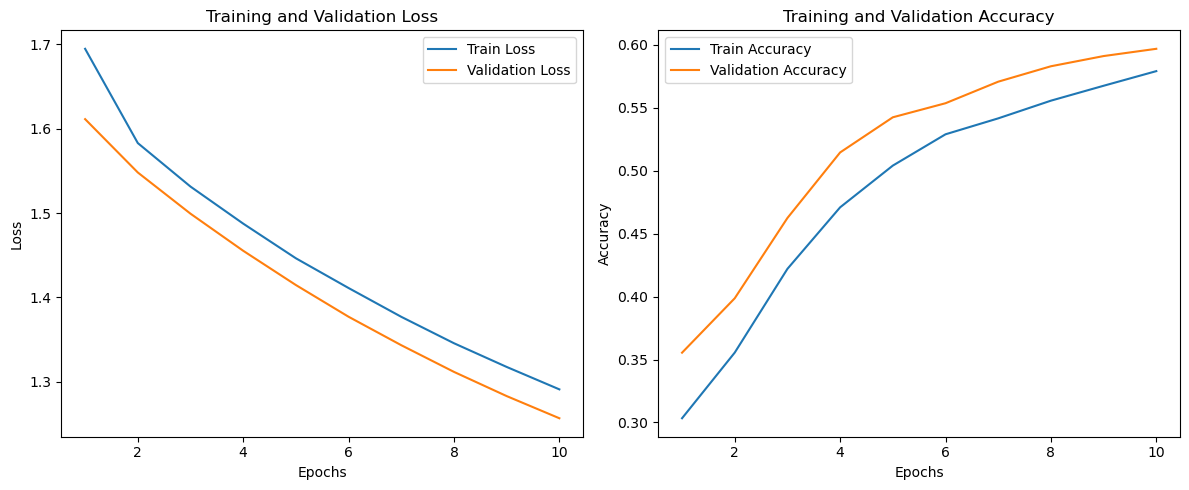

In [4]:
import matplotlib.pyplot as plt
import torch

# 假设有以下初始化：
# model, optimizer, criterion, train_dataloader, val_dataloader, device, epochs

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):

    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch in train_dataloader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        
        # Forward pass
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        
        # Calculate loss
        loss = criterion(logits, labels)
        total_loss += loss.item()
        
        # Calculate training accuracy
        preds = torch.argmax(logits, dim=1)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)
        
        # Backward pass
        loss.backward()
        optimizer.step()
    
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_predictions
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch {epoch+1}, Training loss: {avg_train_loss:.4f}, Training accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            logits = model(input_ids, attention_mask)

            # Calculate validation loss
            loss = criterion(logits, labels)
            val_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.size(0)

    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = correct_predictions / total_predictions
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Validation loss: {avg_val_loss:.4f}, Validation accuracy: {val_accuracy:.4f}")

# 绘制训练过程中的损失和准确率
plt.figure(figsize=(12, 5))

# 绘制损失曲线
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
test_df=pd.read_csv('testdata_with_predictions5.csv')
test_df['comment'] = test_df['comment'].astype(str)
test_df['comment'] = test_df['comment'].fillna('')

# 数据编码
test_encodings = encode(test_df['comment'])
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'])
test_dataloader = DataLoader(test_dataset, batch_size=32)


In [10]:
# 将模型设置为评估模式
model.eval()

predictions = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask = [b.to(device) for b in batch]
        
        # 获取模型的输出
        logits = model(input_ids, attention_mask)
        
        # 获取预测标签
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.cpu().numpy())

# 解码预测的标签回原始标签
test_df['LSTMfreeze_label'] = label_encoder.inverse_transform(predictions)

# 保存结果到文件
test_df.to_csv('testdata_with_predictions6.csv', index=False)

In [11]:
test_df

,文件夹,文件名,comment,nofreeze_label,half_freeze_label,freeze_label,SVMlabel,RFlabel,notransfreeze_label,LSTMfreeze_label
0,1029,15.txt,激动,1,1,0,2,1,2,2
1,1029,15.txt,#从神五到神十九#,0,0,0,2,1,0,0
2,1029,15.txt,#神十九出征仪式#,1,0,0,2,1,0,0
3,1029,15.txt,#中国空间站我们90后来了#,1,1,1,2,1,3,1
4,1029,15.txt,#神十九航天员的出征仪式好可爱#,1,1,1,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...
36014,1109,30.txt,[好运连连],1,1,0,2,1,1,1
36015,1109,30.txt,这次又是什么原因……怎么感觉它三天两头崩一次,4,4,2,2,1,4,2
36016,1109,30.txt,谁给我指个路、、又谁在被保护,2,2,2,2,1,2,2
36017,1109,30.txt,怎么又崩了？干啥了,2,3,2,2,1,2,2
